# Library

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import Dataset
from tokenizers import BertWordPieceTokenizer, Tokenizer
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertForQuestionAnswering,
    BertConfig,
    Trainer,
    TrainingArguments,
)

c:\ProgramData\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BERT

reference: [BERT](https://wikidocs.net/115055) <br>
paper: [BERT](https://arxiv.org/pdf/1810.04805) 

## Implementation

In [29]:
def scaled_dot_product_attention(query, key, value, mask=None):
    matmul_qk = query @ key.transpose(-2, -1)
    depth = query.shape[-1]

    logits = matmul_qk / np.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = F.softmax(logits, dim=1)
    output = attention_weights @ value

    return output, attention_weights


class MultiheadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        assert self.d_model%self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.query_dense = nn.Linear(self.d_model, self.d_model)
        self.key_dense = nn.Linear(self.d_model, self.d_model)
        self.value_dense = nn.Linear(self.d_model, self.d_model)

        self.dense = nn.Linear(self.d_model, self.d_model)
    
    def forward(self, inputs: dict):
        query, key, value = inputs.get('query'), inputs.get('key'), inputs.get('value')
        mask = inputs.get('mask')
        batch_size, seq_len = query.shape[:2]

        query = self.query_dense(query) # batch_size, seq_len, dim
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = query.reshape(batch_size, seq_len, self.num_heads, self.depth)  # batch, seq_len, num_heads, depth
        key = key.reshape(batch_size, seq_len, self.num_heads, self.depth)
        value = value.reshape(batch_size, seq_len, self.num_heads, self.depth)

        query = query.permute(0, 2, 1, 3)   # batch, num_heads, seq_len, depth
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)   # batch, num_heads, seq_len, depth
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)                 # batch, seq_len, num_heads, depth
        concat_attention = scaled_attention.reshape(batch_size, seq_len, self.d_model)  # batch, seq_len, dim

        outputs = self.dense(concat_attention)  # batch, seq_len, dim

        return outputs


class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, num_heads: int, dropout_ratio: float):    
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_ratio = dropout_ratio

        self.multi_head_attention = MultiheadAttention(self.d_model, self.num_heads)
        self.dropout1 = nn.Dropout(self.dropout_ratio)
        self.layer_norm1 = nn.LayerNorm(self.d_model)

        self.ffn = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model),
        )

        self.dropout2 = nn.Dropout(self.dropout_ratio)
        self.layer_norm2 = nn.LayerNorm(self.d_model)

    def forward(self, x, mask=None):
        inputs = {'query': x, 'key': x, 'value': x, 'mask': mask}
        x_multi_head_output = self.multi_head_attention(inputs)
        x_multi_head_output = self.dropout1(x_multi_head_output)
        x = self.layer_norm1(x_multi_head_output + x)
        
        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output)
        output = self.layer_norm2(x + ffn_output)

        return output


class BERT(nn.Module):
    def __init__(
        self,
        seq_len: int,
        vocab_size: int,
        num_layers: int,
        d_model: int,
        d_ff: int,
        num_heads: int,
        dropout_ratio: float,
        ):
        super().__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_ratio = dropout_ratio

        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.positional_embedding = nn.Embedding(self.seq_len, self.d_model)
        self.segment_embedding = nn.Embedding(2, self.d_model)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(self.d_model, self.d_ff, self.num_heads, self.dropout_ratio)
            for _ in range(self.num_layers)
        ])
    
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x *= (self.d_model ** 0.5)

        positional_encoding = (torch.ones(x.shape[:2]).cumsum(axis=1)-1).long()
        positional_embedding = self.positional_embedding(positional_encoding)
        x += positional_embedding

        segment_encoding = torch.zeros(x.shape[:2]).long()
        segment_embedding = self.segment_embedding(segment_encoding)
        x += segment_embedding

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask)
        output = x

        return output

In [31]:
x = torch.randint(0, 1000, (32, 20))
x

bert = BERT(20, 1000, 12, 768, 2048, 12, 0.1)
bert(x)

tensor([[[-0.2906, -0.6584,  1.9619,  ..., -1.0357, -0.2678,  0.5728],
         [-0.0104, -1.9197,  1.0588,  ..., -0.2179, -1.6125, -0.0701],
         [ 0.5030,  0.0756,  1.1953,  ...,  0.5741, -1.0067,  1.6260],
         ...,
         [-0.1088, -0.2704,  0.4653,  ..., -0.2513, -1.8823, -0.3770],
         [ 0.6014, -1.2329,  0.6875,  ..., -0.1052, -1.5198,  0.4144],
         [ 0.1390, -1.5423,  0.5434,  ..., -0.9341, -0.8175, -0.2473]],

        [[ 0.2578,  0.4389, -0.5429,  ..., -1.3440,  0.8259, -0.4212],
         [-0.2401, -0.3437, -0.2433,  ..., -1.4168, -0.0399,  0.1204],
         [ 1.0967, -0.4443,  0.7128,  ..., -1.0174,  1.0468,  0.8848],
         ...,
         [-0.5167, -0.3882, -0.8720,  ...,  0.1111,  0.3167, -0.2946],
         [ 0.3027, -1.2595,  0.0768,  ..., -0.4451,  0.6046, -0.4611],
         [-0.8294,  0.0169,  0.5167,  ..., -0.1644,  0.0142,  1.4447]],

        [[ 0.4527, -0.6503,  0.2345,  ..., -0.1982, -1.2915,  0.1563],
         [ 0.8184, -0.3630,  0.5080,  ...,  0

## Pre-training

### Tokenizer

### Pre-training

## Fine-tuning

### Sentiment Analysis

In [32]:
dataset = load_dataset('imdb')

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 426128.28 examples/s]


In [63]:
train_data = dataset['train'].select(range(2000))
eval_data = dataset['test'].select(range(2000))

In [64]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocessing(row):
    return tokenizer(row['text'], truncation=True, max_length=256, padding='max_length')

tokenized_train_data = train_data.map(preprocessing, batched=True)
tokenized_eval_data = eval_data.map(preprocessing, batched=True)

In [73]:
train_data = [
    {'input_ids': row.get('input_ids'),
     'token_type_ids': row.get('token_type_ids'),
     'attention_mask': row.get('attention_mask'),
     'label': row.get('label'),
    } for row in tokenized_train_data
]
eval_data = [
    {'input_ids': row.get('input_ids'),
     'token_type_ids': row.get('token_type_ids'),
     'attention_mask': row.get('attention_mask'),
     'label': row.get('label'),
    } for row in tokenized_eval_data
]

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.data[idx].get('input_ids'),
            'attention_mask': self.data[idx].get('attention_mask'),
            'labels': self.data[idx].get('label'),
        }

train_dataset = IMDBDataset(train_data)
eval_dataset = IMDBDataset(eval_data)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)

model = BertForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

#### 유튜브

In [77]:
import urllib.request

urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/e9t/nsmc/refs/heads/master/ratings_train.txt',
    filename='data/ratings_train.txt',
)
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/e9t/nsmc/refs/heads/master/ratings_test.txt',
    filename='data/ratings_test.txt',
)

('data/ratings_test.txt', <http.client.HTTPMessage at 0x25b7b31fa30>)

In [2]:
train = pd.read_table('data/ratings_train.txt', usecols=['document', 'label']).iloc[:5000]
valid = pd.read_table('data/ratings_test.txt', usecols=['document', 'label']).iloc[:5000]

In [3]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-multilingual-uncased')

<Axes: >

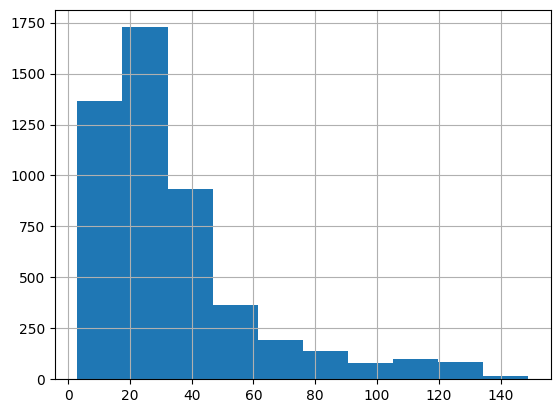

In [4]:
train['tokenized_comment'] = train.document.apply(lambda x: tokenizer(x))
valid['tokenized_comment'] = valid.document.apply(lambda x: tokenizer(x))
train.tokenized_comment.apply(lambda x: x.get('input_ids')).apply(len).hist()

In [6]:
tokenized_train_comment = tokenizer(
    train.document.tolist(),
    return_tensors='pt',
    padding='max_length',
    max_length=100,
    truncation=True,
)
tokenized_valid_comment = tokenizer(
    valid.document.tolist(),
    return_tensors='pt',
    padding='max_length',
    max_length=100,
    truncation=True,
)

train_data = [
    {'input_ids': input_ids,
     'token_type_ids': token_type_ids,
     'attention_mask': attention_mask,
     'label': label,
    } 
    for input_ids, token_type_ids, attention_mask, label 
    in zip(tokenized_train_comment.get('input_ids'),
           tokenized_train_comment.get('token_type_ids'),
           tokenized_train_comment.get('attention_mask'),
           train.label.values)
]

eval_data = [
    {'input_ids': input_ids,
     'token_type_ids': token_type_ids,
     'attention_mask': attention_mask,
     'label': label,
    } 
    for input_ids, token_type_ids, attention_mask, label 
    in zip(tokenized_valid_comment.get('input_ids'),
           tokenized_valid_comment.get('token_type_ids'),
           tokenized_valid_comment.get('attention_mask'),
           train.label.values)
]

class CommentDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.data[idx].get('input_ids'),
            'attention_mask': self.data[idx].get('attention_mask'),
            'labels': self.data[idx].get('label'),
        }

train_dataset = CommentDataset(train_data)
eval_dataset = CommentDataset(eval_data)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)

model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-uncased')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

In [24]:
model(**tokenizer(valid.document.iloc[3], return_tensors='pt')).logits.argmax(axis=-1)

tensor([0])

### Natural Language Infernce (NLI)

### Question and Answering